The following code was used to generate the graphs and perform the numerical analysis presented in this study

# Part 3

## Wave Equation Solver: Explanation of Functions and Mathematical Basis

### `exact_solution(x, t)`
This function returns the **manufactured exact solution** to the wave equation:
$
u(x, t) = \sin(\pi x) \cos(\pi t)
$
This solution satisfies the 1D wave equation under appropriate boundary and initial conditions. It is often used for verification of numerical solvers via the Method of Manufactured Solutions (MMS).

---

### `exact_velocity(x, t)`
This function returns the **time derivative** of the exact solution:
$
\frac{\partial u}{\partial t}(x, t) = -\pi \sin(\pi x) \sin(\pi t)
$
This is used to initialize the velocity field `v` in the numerical solver.

---

### `stiffness_profile(x, E0=1.0, alpha=2.0)`
This defines a **non-uniform Young’s modulus (stiffness)** profile:
$
E(x) = E_0 (1 + \alpha x)
$
The parameter `alpha` controls how rapidly the stiffness increases along the domain. `E0` is the baseline stiffness.

---

### `density_profile(x, rho0=1.0, beta=1.0)`
This defines a **non-uniform density** profile:
$
\rho(x) = \rho_0 (1 + \beta x)
$
The parameter `beta` controls how rapidly the density increases along the domain. `rho0` is the baseline density.

---

### `rk4_step(u, v, dt, E_half, rho, h, N)`
This function performs **one Runge-Kutta 4th-order (RK4)** time integration step for the wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x} \left( E(x) \frac{\partial u}{\partial x} \right)
$

The method is applied to the system written as first-order in time:
$
\frac{\partial u}{\partial t} = v, \quad \frac{\partial v}{\partial t} = \frac{1}{\rho} \frac{\partial}{\partial x}\left(E(x) \frac{\partial u}{\partial x} \right)
$

- `u`: displacement field at current time
- `v`: velocity field at current time
- `dt`: time step
- `E_half`: stiffness values at midpoints between grid nodes (used for centered differences)
- `rho`: density at each node
- `h`: spatial step size
- `N`: number of interior grid points

The internal function `compute_F(u)` computes the finite-difference approximation of:
$
\frac{1}{\rho(x)} \cdot \left[ \frac{\partial}{\partial x}\left( E(x) \frac{\partial u}{\partial x} \right) \right]
$
using centered second-order finite differences.

The RK4 method proceeds through four stages (k1, k2, k3, k4) to update `u` and `v` with high temporal accuracy. Dirichlet boundary conditions `u[0] = u[-1] = 0` are enforced after each step.

---


In [1]:
import numpy as np

# --- Exact manufactured solution and its derivatives ---
def exact_solution(x, t):
    return np.sin(np.pi * x) * np.cos(np.pi * t)

def exact_velocity(x, t):
    return -np.pi * np.sin(np.pi * x) * np.sin(np.pi * t)

# Stiffness and Density Equations

def stiffness_profile(x, E0=1.0, alpha=2.0):
    return E0 * (1 + alpha * x)
def density_profile(x, rho0=1.0, beta=1.0):
    return rho0 * (1 + beta * x)

def rk4_step(u, v, dt, E_half, rho, h, N):
    def compute_F(u):
        F = np.zeros_like(u)
        for j in range(1, N + 1):
            F[j] = (
                E_half[j] * (u[j+1] - u[j]) -
                E_half[j-1] * (u[j] - u[j-1])
            ) / h**2
        return F / rho
    def f(u, v):
        return v, compute_F(u)
    du1, dv1 = f(u, v)
    du2, dv2 = f(u + 0.5*dt*du1, v + 0.5*dt*dv1)
    du3, dv3 = f(u + 0.5*dt*du2, v + 0.5*dt*dv2)
    du4, dv4 = f(u + dt*du3, v + dt*dv3)
    u_new = u + dt/6 * (du1 + 2*du2 + 2*du3 + du4)
    v_new = v + dt/6 * (dv1 + 2*dv2 + 2*dv3 + dv4)
    
    u_new[0] = u_new[-1] = 0
    v_new[0] = v_new[-1] = 0
    return u_new, v_new

## Wave Solver with Dirichlet Boundary Conditions: Code and Mathematical Explanation

### `wave_solver(N, dt, T)`

This function numerically solves the 1D wave equation with **Dirichlet-Dirichlet boundary conditions** using the Runge-Kutta 4th-order (RK4) time integration scheme.

---

### **Mathematical Model**

We solve the 1D wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x} \left( E(x) \frac{\partial u}{\partial x} \right)
$
with fixed (Dirichlet) boundary conditions:
$
u(0,t) = u(1,t) = 0
$

In this implementation, the material is assumed to be **homogeneous**:
- $ E(x) = 1 $
- $ \rho(x) = 1 $

---

### **Inputs**
- `N`: Number of interior spatial grid points.
- `dt`: Time step size.
- `T`: Total simulation time.

---

### **Steps in the Function**

1. **Domain and Grid Setup**:
    ```python
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    ```
    A uniform grid is created over the domain $[0, 1]$, with `N + 2` points including boundary nodes.

2. **Initial Conditions**:
    ```python
    u = exact_solution(x, 0)
    v = exact_velocity(x, 0)
    ```
    The displacement `u` and velocity `v` are initialized using exact analytical solutions for validation.

3. **Material Properties**:
    ```python
    E = np.ones_like(x)
    rho = np.ones_like(x)
    ```
    Sets constant stiffness $ E(x) = 1 $ and density $ \rho(x) = 1 $.

    Midpoint values of stiffness are precomputed as:
    ```python
    E_half = 0.5 * (E[:-1] + E[1:])
    ```

4. **Time Integration Loop**:
    ```python
    while t < T - 1e-10:
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt
    ```
    Advances the solution in time using a fourth-order Runge-Kutta integrator (`rk4_step`). Boundary conditions are enforced within the RK4 step to ensure $ u[0] = u[-1] = 0 $.

5. **Return Values**:
    ```python
    return x, u
    ```
    Returns the spatial grid `x` and the final displacement field `u(x, T)` at the final time.

---

This solver provides a reliable and accurate method to simulate wave propagation in a 1D domain with fixed ends and constant material properties. It is suitable for comparison with analytical solutions and for verifying numerical convergence.

In [2]:
# --- Solver with fixed Dirichlet-Dirichlet boundary conditions ---
def wave_solver(N, dt, T):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    u = exact_solution(x, 0)
    v = exact_velocity(x, 0)
    E = np.ones_like(x)
    rho = np.ones_like(x)
    E_half = 0.5 * (E[:-1] + E[1:])

    t = 0.0
    while t < T - 1e-10:
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt

    return x, u

## Error Convergence Test (Fixed Time Step)

This code evaluates the **spatial convergence** of the numerical wave equation solver using a fixed time step `dt = 1e-3`. The solver is tested for multiple grid resolutions: `N = 20, 40, 80, 160`, and the corresponding grid spacing `h = 1 / (N + 1)` is computed. For each case, the numerical solution `u_num` at time `T = 0.5` is compared against the exact analytical solution `u_ex = sin(πx) cos(πt)`. The L2 error is computed using the formula:

$$
\text{error} = \sqrt{h \sum_i (u_{\text{num},i} - u_{\text{ex},i})^2}
$$

The observed convergence rate is calculated between successive resolutions using a logarithmic ratio. The results are printed in tabular form showing the number of points, grid spacing, error, and observed order of accuracy. A log-log plot is also generated to visualize the convergence trend and compare it against a reference slope corresponding to **second-order accuracy**, which is expected due to the second-order finite difference discretization in space.


 N     h         Error       Observed Order
---------------------------------------------
20    0.04762   1.035e-03     ---
40    0.02439   2.717e-04     2.00
80    0.01235   6.962e-05     2.00
160   0.00621   1.762e-05     2.00


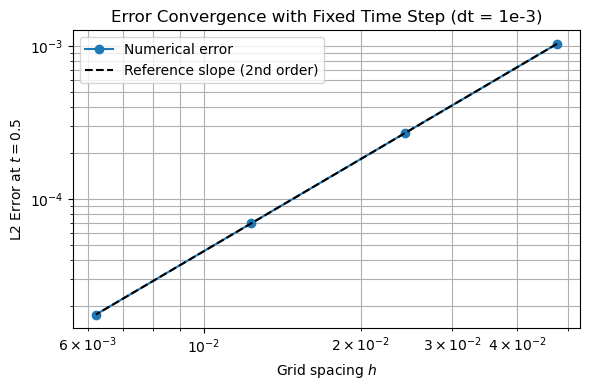

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Error convergence test with fixed dt ---
errors = []
hs = []
T = 0.5
Ns = [20, 40, 80, 160]
print(" N     h         Error       Observed Order")
print("---------------------------------------------")
for i, N in enumerate(Ns):
    h = 1 / (N + 1)
    dt = 1e-3
    x, u_num = wave_solver(N, dt, T)
    u_ex = exact_solution(x, T)
    error = np.sqrt(np.sum((u_num - u_ex)**2) * h)
    hs.append(h)
    errors.append(error)
    if i > 0:
        rate = np.log(errors[i] / errors[i - 1]) / np.log(hs[i] / hs[i - 1])
        print(f"{N:<5d} {h:.5f}   {error:.3e}     {rate:.2f}")
    else:
        print(f"{N:<5d} {h:.5f}   {error:.3e}     ---")

# --- Plot error convergence ---
plt.figure(figsize=(6, 4))
plt.loglog(hs, errors, 'o-', label='Numerical error')
ref_line = errors[0] * (np.array(hs) / hs[0])**2
plt.loglog(hs, ref_line, 'k--', label='Reference slope (2nd order)')
plt.xlabel('Grid spacing $h$')
plt.ylabel('L2 Error at $t = 0.5$')
plt.title('Error Convergence with Fixed Time Step (dt = 1e-3)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


The code below performs a temporal convergence study of the one-dimensional wave equation with constant material properties, using the fourth-order Runge–Kutta (RK4) time integration scheme. For each spatial resolution $ N \in \{100, 200, 400, 800\} $, the code computes the numerical solution up to final time $ T = 0.5 $ across a sequence of decreasing time step sizes $ \Delta t = 0.1 / 2^k $, where $ k = 0, 1, \dots, 9 $. The exact solution $ u(x,t) = \sin(\pi x)\cos(\pi t) $ is used to compute the 2-norm error of the numerical approximation at each $ \Delta t $. These errors are then printed along with the observed convergence order, and plotted on a log-log scale to compare against a reference slope representing $ \mathcal{O}(\Delta t^4) $ behavior. The resulting plot visualizes how time discretization error behaves across resolutions and helps verify the expected fourth-order temporal accuracy of RK4 before spatial error dominates.


<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:33: SyntaxWarning: invalid escape sequence '\D'
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/632257138.py:31: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dt_list, ref_line, 'k--', label='O($\Delta t^4$) reference')
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/632257138.py:33: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("Time step size ($\Delta t$)")



N = 100
dt			Error			Order
------------------------------------------------------------
1.000000e-01	2.051499e+02	-
5.000000e-02	1.933260e+09	-23.17
2.500000e-02	9.476209e+09	-2.29
1.250000e-02	4.479800e-05	47.59
6.250000e-03	4.477738e-05	0.00
3.125000e-03	4.477610e-05	0.00
1.562500e-03	4.477601e-05	0.00
7.812500e-04	4.477601e-05	0.00
3.906250e-04	4.477601e-05	0.00
1.953125e-04	4.477601e-05	0.00

N = 200
dt			Error			Order
------------------------------------------------------------
1.000000e-01	2.524509e+08	-
5.000000e-02	1.158525e+21	-42.06
2.500000e-02	3.543056e+34	-44.80
1.250000e-02	3.616902e+35	-3.35
6.250000e-03	1.130714e-05	134.55
3.125000e-03	1.130585e-05	0.00
1.562500e-03	1.130577e-05	0.00
7.812500e-04	1.130577e-05	0.00
3.906250e-04	1.130576e-05	0.00
1.953125e-04	1.130576e-05	0.00

N = 400
dt			Error			Order
------------------------------------------------------------
1.000000e-01	3.894039e+14	-
5.000000e-02	2.174148e+33	-62.28
2.500000e-02	3.338057e+59	-86.99
1.250000e-02	2

/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/632257138.py:20: RuntimeWarning: overflow encountered in square
  error = np.sqrt(h * np.sum((u_num - u_ex)**2))
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/632257138.py:25: RuntimeWarning: divide by zero encountered in log
  order = np.log(errors[i-1] / errors[i]) / np.log(dt_list[i-1] / dt_list[i])


6.250000e-03	inf	-inf
3.125000e-03	inf	nan


/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/632257138.py:25: RuntimeWarning: invalid value encountered in scalar divide
  order = np.log(errors[i-1] / errors[i]) / np.log(dt_list[i-1] / dt_list[i])


1.562500e-03	7.119206e-07	inf
7.812500e-04	7.119155e-07	0.00
3.906250e-04	7.119152e-07	0.00
1.953125e-04	7.119152e-07	0.00


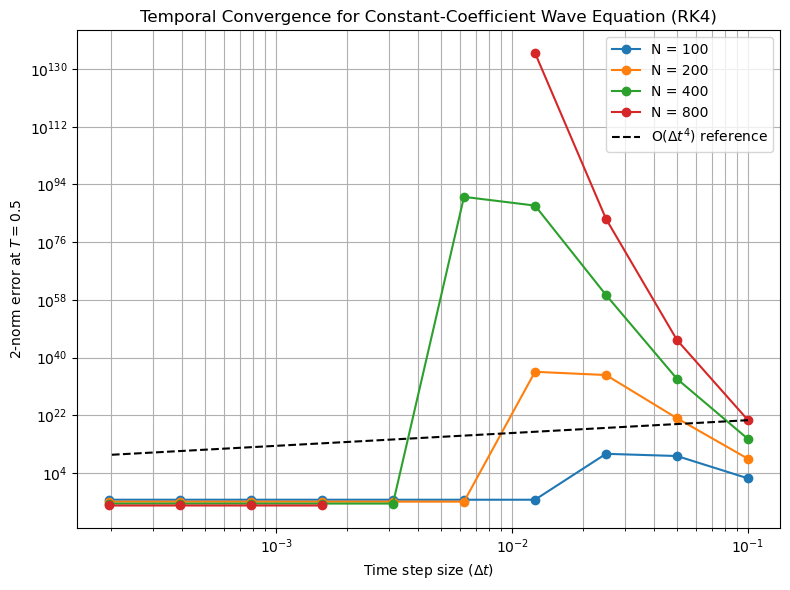

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- Main plotting and printing function ---
def plot_time_convergence():
    T = 0.5
    dt_list = [0.1 / (2**k) for k in range(10)]
    N_values = [100, 200, 400, 800]
    plt.figure(figsize=(8, 6))

    for N in N_values:
        errors = []
        print(f"\nN = {N}")
        print("dt\t\t\tError\t\t\tOrder")
        print("-" * 60)
        for i, dt in enumerate(dt_list):
            x, u_num = wave_solver(N, dt, T)
            u_ex = exact_solution(x, T)
            h = x[1] - x[0]
            error = np.sqrt(h * np.sum((u_num - u_ex)**2))
            errors.append(error)
            if i == 0:
                print(f"{dt:.6e}\t{error:.6e}\t-")
            else:
                order = np.log(errors[i-1] / errors[i]) / np.log(dt_list[i-1] / dt_list[i])
                print(f"{dt:.6e}\t{error:.6e}\t{order:.2f}")
        plt.loglog(dt_list, errors, 'o-', label=f'N = {N}')

    # Add dt^4 reference slope
    ref_line = [errors[0] * (dt / dt_list[0])**4 for dt in dt_list]
    plt.loglog(dt_list, ref_line, 'k--', label='O($\Delta t^4$) reference')

    plt.xlabel("Time step size ($\Delta t$)")
    plt.ylabel("2-norm error at $T=0.5$")
    plt.title("Temporal Convergence for Constant-Coefficient Wave Equation (RK4)")
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run it
plot_time_convergence()


The code below performs a temporal convergence study for the one-dimensional wave equation using the classical fourth-order Runge–Kutta (RK4) method. The solver assumes constant stiffness $ E = 1 $ and density $ \rho = 1 $, and enforces Dirichlet boundary conditions. The exact solution is manufactured as $ u(x,t) = \sin(\pi x)\cos(\pi t) $, allowing the computation of 2-norm errors between the numerical and analytical solutions at final time $ T = 0.1 $. Two lists of time step sizes $ \Delta t $ — one coarse and one fine — are used to examine how the error behaves under small variations in time discretization. For each $ \Delta t $, the numerical error is computed and convergence order is reported. The resulting errors are plotted on a log-log scale alongside a reference curve proportional to $ \mathcal{O}(\Delta t^4) $, highlighting the expected fourth-order accuracy of the RK4 integrator in the pre-asymptotic regime near the spatial error floor.



Coarse Time Steps:
Δt		Error			Order
--------------------------------------------------
0.0040450	1.769803e-07	-
0.0040470	1.773016e-07	3.67
0.0040490	1.777009e-07	4.55

Fine Time Steps:
Δt		Error			Order
--------------------------------------------------
0.0040450	1.769803e-07	-
0.0040455	1.772764e-07	13.52
0.0040460	1.772271e-07	-2.25
0.0040465	1.772460e-07	0.86
0.0040470	1.772912e-07	2.06
0.0040475	1.774581e-07	7.62
0.0040480	1.776667e-07	9.51
0.0040485	1.778952e-07	10.41
0.0040490	1.777549e-07	-6.39


<>:71: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
<>:71: SyntaxWarning: invalid escape sequence '\D'
<>:72: SyntaxWarning: invalid escape sequence '\D'
<>:74: SyntaxWarning: invalid escape sequence '\D'
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/2752987435.py:71: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dt_list_coarse, errors_coarse, 's-', label='Coarse $\Delta t$')
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/2752987435.py:72: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dt_list_fine, errors_fine, 'o-', label='Fine $\Delta t$')
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/2752987435.py:74: SyntaxWarning: invalid escape sequence '\D'
  plt.loglog(dt_list_fine, ref_line, 'k--', label='O($\Delta t^4$)')


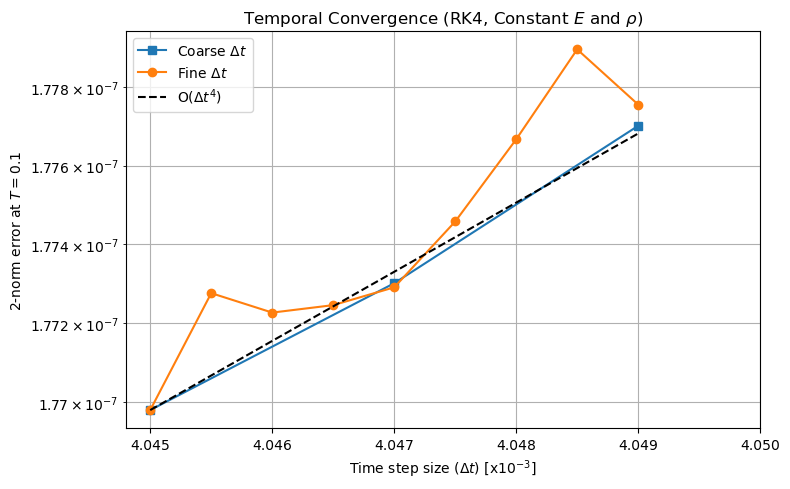

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Wave solver for fixed N and variable dt (constant E, rho) ---
def wave_solver_time(N, dt, T):
    x = np.linspace(0, 1, N + 2)
    h = x[1] - x[0]
    E = np.ones_like(x)
    rho = np.ones_like(x)
    E_half = 0.5 * (E[:-1] + E[1:])
    u = exact_solution(x, 0)
    v = exact_velocity(x, 0)

    def compute_F(u):
        F = np.zeros(N + 2)
        for j in range(1, N + 1):
            F[j] = (
                E_half[j] * (u[j + 1] - u[j]) -
                E_half[j - 1] * (u[j] - u[j - 1])
            ) / h**2
        return F / rho

    t = 0
    while t < T:
        if t + dt > T:
            dt = T - t
        k1u = dt * v
        k1v = dt * compute_F(u)
        k2u = dt * (v + 0.5 * k1v)
        k2v = dt * compute_F(u + 0.5 * k1u)
        k3u = dt * (v + 0.5 * k2v)
        k3v = dt * compute_F(u + 0.5 * k2u)
        k4u = dt * (v + k3v)
        k4v = dt * compute_F(u + k3u)
        u += (k1u + 2 * k2u + 2 * k3u + k4u) / 6
        v += (k1v + 2 * k2v + 2 * k3v + k4v) / 6
        t += dt

    return x, u

# --- Time convergence test with two dt lists and printout ---
def time_convergence():
    N = 400
    T = 0.1
    dt_list_coarse = np.arange(4.045e-3, 4.0491e-3, 0.002e-3).tolist()
    dt_list_fine = np.arange(4.045e-3, 4.0491e-3, 0.0005e-3).tolist()

    def compute_errors(dt_list, label):
        errors = []
        print(f"\n{label} Time Steps:")
        print("Δt\t\tError\t\t\tOrder")
        print("-" * 50)
        for i, dt in enumerate(dt_list):
            x, u_num = wave_solver_time(N, dt, T)
            u_ex = exact_solution(x, T)
            h = x[1] - x[0]
            error = np.sqrt(h * np.sum((u_num - u_ex)**2))
            errors.append(error)
            if i == 0:
                print(f"{dt:.7f}\t{error:.6e}\t-")
            else:
                order = np.log(errors[i - 1] / error) / np.log(dt_list[i - 1] / dt)
                print(f"{dt:.7f}\t{error:.6e}\t{order:.2f}")
        return errors

    errors_coarse = compute_errors(dt_list_coarse, "Coarse")
    errors_fine = compute_errors(dt_list_fine, "Fine")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.loglog(dt_list_coarse, errors_coarse, 's-', label='Coarse $\Delta t$')
    plt.loglog(dt_list_fine, errors_fine, 'o-', label='Fine $\Delta t$')
    ref_line = [errors_fine[0] * (dt / dt_list_fine[0])**4 for dt in dt_list_fine]
    plt.loglog(dt_list_fine, ref_line, 'k--', label='O($\Delta t^4$)')

    # Format x-axis ticks as multiples of 1e-3
    xticks = np.linspace(4.045e-3, 4.05e-3, 6)
    xtick_labels = [f"{1e3 * tick:.3f}" for tick in xticks]
    plt.xticks(xticks, xtick_labels)
    plt.xlabel("Time step size ($\\Delta t$) [x$10^{-3}$]")
    plt.ylabel("2-norm error at $T = 0.1$")
    plt.title("Temporal Convergence (RK4, Constant $E$ and $\\rho$)")
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run it
time_convergence()


The code below visualizes the qualitative behavior of numerical error in a time-dependent wave equation solver as a function of the time step size $ \Delta t $. It illustrates the contributions from spatial discretization error (assumed constant), fourth-order time integration error (scaling as $ \mathcal{O}(\Delta t^4) $), and exponential instability growth beyond a critical time step threshold (the CFL limit, here set to $ 10^{-2} $). The total observed error is modeled as the combination of time and spatial error in the stable regime, and replaced by rapidly growing instability error beyond the CFL threshold. The log-log plot clearly separates these regimes and helps conceptualize why the expected convergence rate is difficult to observe in practice: a narrow range exists where time error dominates, bounded on one side by spatial resolution limits and on the other by numerical instability. This synthetic model is useful for interpreting convergence plots and diagnosing deviations from ideal behavior in real simulations.


<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/4c/kthk6sf172l579vt6d_6zkf40000gn/T/ipykernel_18698/2859070145.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.loglog(dt_vals, time_error, 'b-', label='Time Discretization Error ($\mathcal{O}(\\Delta t^4)$)')


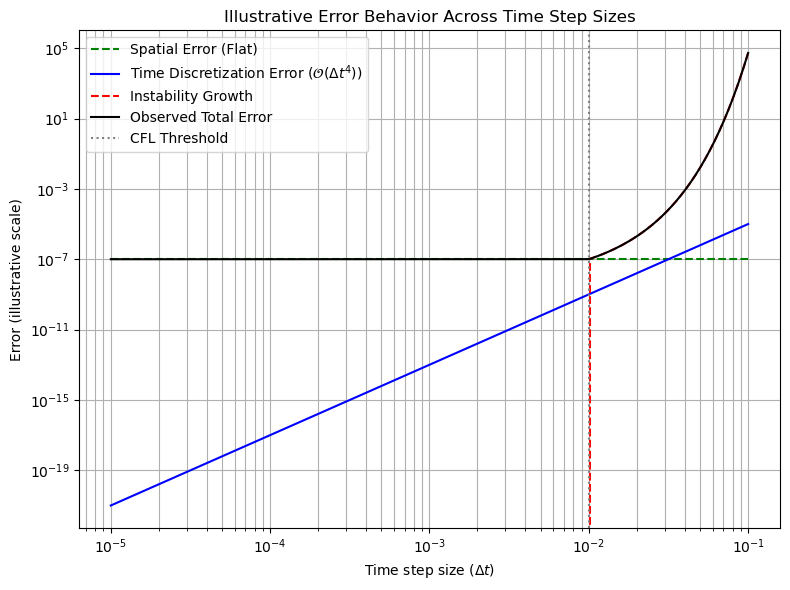

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate mock data for illustrative purposes
dt_vals = np.logspace(-5, -1, 400)  # Log-distributed time steps

# Artificial curves for demonstration
# Assume spatial error is flat and dominates at low dt
spatial_error = np.full_like(dt_vals, 1e-7)

# Time integration error is 4th order and dominates at high dt until instability
time_error = 1e-1 * dt_vals**4

# Instability region begins when dt > dt_CFL (e.g., ~1e-2)
instability_error = np.zeros_like(dt_vals)
dt_CFL = 1e-2
instability_mask = dt_vals > dt_CFL
instability_error[instability_mask] = 1e-7 * np.exp(300 * (dt_vals[instability_mask] - dt_CFL))

# Total error is the max of time+spatial error and instability
total_error = np.where(instability_mask, instability_error, time_error + spatial_error)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(dt_vals, spatial_error, 'g--', label='Spatial Error (Flat)')
plt.loglog(dt_vals, time_error, 'b-', label='Time Discretization Error ($\mathcal{O}(\\Delta t^4)$)')
plt.loglog(dt_vals, instability_error, 'r--', label='Instability Growth')
plt.loglog(dt_vals, total_error, 'k', label='Observed Total Error')
plt.axvline(x=dt_CFL, color='gray', linestyle=':', label='CFL Threshold')

plt.xlabel("Time step size ($\\Delta t$)")
plt.ylabel("Error (illustrative scale)")
plt.title("Illustrative Error Behavior Across Time Step Sizes")
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()


The code below compares the numerical and exact solutions of the one-dimensional wave equation with constant material properties at selected time values $ T = 0.1, 0.25, 0.5 $. The numerical solution is computed using the `wave_solver` function, which employs second-order spatial discretization and fourth-order Runge–Kutta (RK4) time integration under clamped boundary conditions. For each time snapshot, the code computes the exact solution $ u(x, T) = \sin(\pi x)\cos(\pi T) $, then plots both the numerical and exact solutions on the left subplot and their pointwise absolute difference (error) on the right subplot. This side-by-side visualization provides clear insight into the accuracy and behavior of the numerical method over time, demonstrating how well it captures the true dynamics of the wave equation.


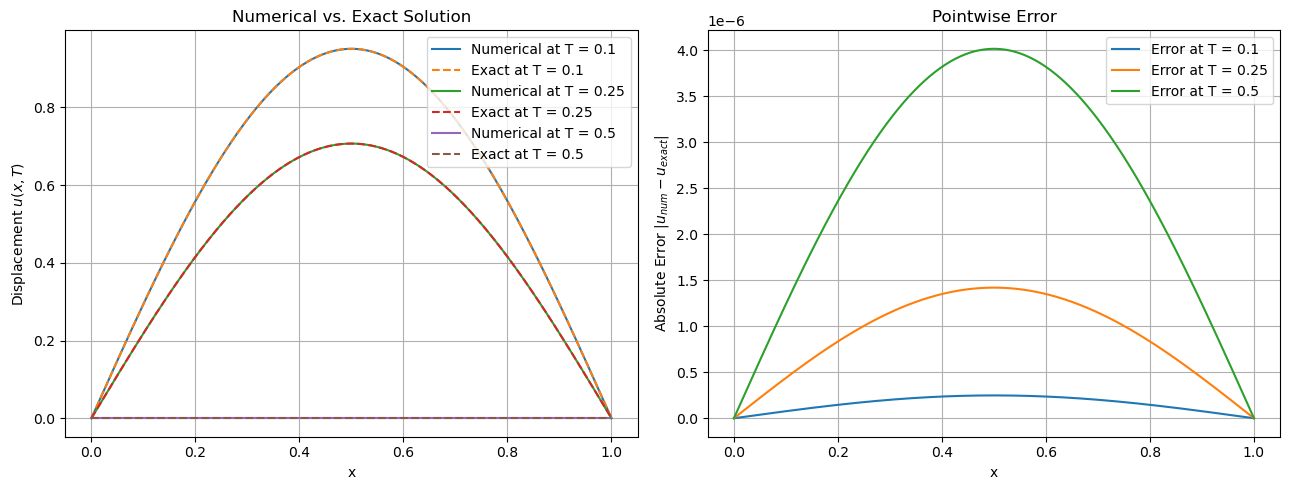

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters ---
N = 400
dt = 3.125e-3
T_values = [0.1, 0.25, 0.5]

# --- Create subplots for solution and error ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), sharex=True)

# Plot numerical vs. exact
for T in T_values:
    x, u_num = wave_solver(N, dt, T)
    u_ex = exact_solution(x, T)
    ax1.plot(x, u_num, label=f"Numerical at T = {T}")
    ax1.plot(x, u_ex, '--', label=f"Exact at T = {T}")
    ax2.plot(x, np.abs(u_num - u_ex), label=f"Error at T = {T}")

# Style first plot
ax1.set_title("Numerical vs. Exact Solution")
ax1.set_xlabel("x")
ax1.set_ylabel("Displacement $u(x,T)$")
ax1.grid(True)
ax1.legend()

# Style second plot
ax2.set_title("Pointwise Error")
ax2.set_xlabel("x")
ax2.set_ylabel("Absolute Error $|u_{num} - u_{exact}|$")
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


The code below numerically solves the one-dimensional wave equation with spatially varying material properties using the classical fourth-order Runge–Kutta (RK4) method. The stiffness $ E(x) $ and density $ \rho(x) $ vary linearly along the rod, representing a nonuniform medium. The initial displacement and velocity are set using a manufactured exact solution $ u(x, 0) = \sin(\pi x) $ and its corresponding time derivative. The domain is discretized into $ N+2 $ points, and the solution is advanced in time using a time step $ \Delta t $, while enforcing Dirichlet boundary conditions at both ends $ u(0,t) = u(1,t) = 0 $. The function `compute_F(u)` constructs the spatial second derivative in conservative form, incorporating the nonuniform stiffness and density profiles. The displacement profile $ u(x, T) $ is computed and plotted at multiple time snapshots to illustrate how wave propagation is affected by the varying material properties.


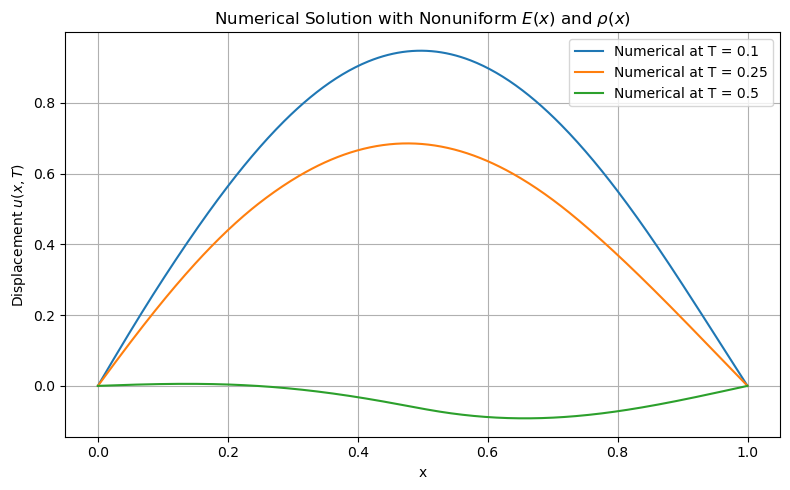

In [8]:
import numpy as np
import matplotlib.pyplot as plt
# --- Wave solver with nonuniform E(x), rho(x) ---
def wave_solver_nonuniform(N, dt, T):
    x = np.linspace(0, 1, N + 2)
    h = x[1] - x[0]

    # Nonuniform material properties
    E = 1 + 0.5 * x
    rho = 1 + 0.3 * x
    E_half = 0.5 * (E[:-1] + E[1:])

    # Initial conditions
    u = exact_solution(x, 0)
    v = exact_velocity(x, 0)
    u[0] = u[-1] = 0
    v[0] = v[-1] = 0

    t = 0
    while t < T:
        if t + dt > T:
            dt = T - t
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt

    return x, u

# --- Parameters ---
N = 400
dt = 3.125e-3
T_values = [0.1, 0.25, 0.5]

# --- Plot numerical solution at different times with nonuniform properties ---
plt.figure(figsize=(8, 5))
for T in T_values:
    x, u_num = wave_solver_nonuniform(N, dt, T)
    plt.plot(x, u_num, label=f"Numerical at T = {T}")

plt.xlabel("x")
plt.ylabel("Displacement $u(x,T)$")
plt.title("Numerical Solution with Nonuniform $E(x)$ and $\\rho(x)$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Part 4: Question 1

## Modal Analysis of 1D Elastic Rod with Varying Stiffness and Density

This code performs a **modal analysis** of a 1D wave equation with spatially varying material properties. It simulates how changes in stiffness (`E(x)`) and density (`ρ(x)`) affect the dominant vibrational frequency of the system. The analysis is based on tracking the midpoint displacement over time and applying a **Fast Fourier Transform (FFT)** to extract frequency content.

---

### Mathematical Model

The wave equation with variable coefficients is:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x}\left( E(x) \frac{\partial u}{\partial x} \right)
$
- $ u(x, t) $: displacement field.
- $ E(x) = 1 + \alpha x $: spatially varying stiffness.
- $ \rho(x) = 1 + \beta x $: spatially varying density.
- Dirichlet boundary conditions: $ u(0,t) = u(1,t) = 0 $.

The simulation domain is $ x \in [0, 1] $, and the initial displacement is:
$
u(x, 0) = \sin(\pi x), \quad \frac{\partial u}{\partial t}(x, 0) = 0
$
This excites primarily the first vibration mode of the system.

---

### Function Descriptions

- `wave_solver_modes(...)`:
  - Initializes displacement and velocity fields.
  - Computes material property arrays `E`, `ρ`, and midpoint values `E_half`.
  - Tracks the displacement at the **center of the domain** (midpoint node).
  - Advances the wave equation in time using `rk4_step` (4th-order Runge-Kutta).
  - Returns the time array and the midpoint displacement history.

---

### Parameter Sweep

The code evaluates four cases:
- **Uniform**: $ \alpha = 0, \beta = 0 $
- **Stiffening**: $ \alpha = 1, \beta = 0 $
- **Densifying**: $ \alpha = 0, \beta = 1 $
- **Stiffening + Densifying**: $ \alpha = 1, \beta = 1 $

Each case simulates the system for `T = 5.0` seconds and records the midpoint motion over time.

---

### Frequency Analysis (FFT)

- The FFT of the midpoint displacement is computed to extract frequency content.
- The DC component is removed (mean-subtracted signal).
- Only the positive frequency components (up to Nyquist) are retained.
- The **dominant frequency** is extracted using `np.argmax` on the FFT amplitude.

---

### Visualization

- A plot is generated to compare the FFT amplitude spectra for each case, limited to the 0–10 Hz range.
- The plot shows how increasing stiffness raises the natural frequency, while increasing density lowers it—consistent with the physical relationship:
$
f \propto \sqrt{\frac{E}{\rho}}
$

This analysis is useful for understanding how material gradients affect vibrational behavior, and can inform the design of tapered structures or functionally graded materials.


Dominant frequencies (in Hz) for each (alpha, beta):
alpha=0.0, beta=0.0: Dominant Frequency = 0.5999 Hz
alpha=1.0, beta=0.0: Dominant Frequency = 0.5999 Hz
alpha=0.0, beta=1.0: Dominant Frequency = 0.4000 Hz
alpha=1.0, beta=1.0: Dominant Frequency = 0.5999 Hz


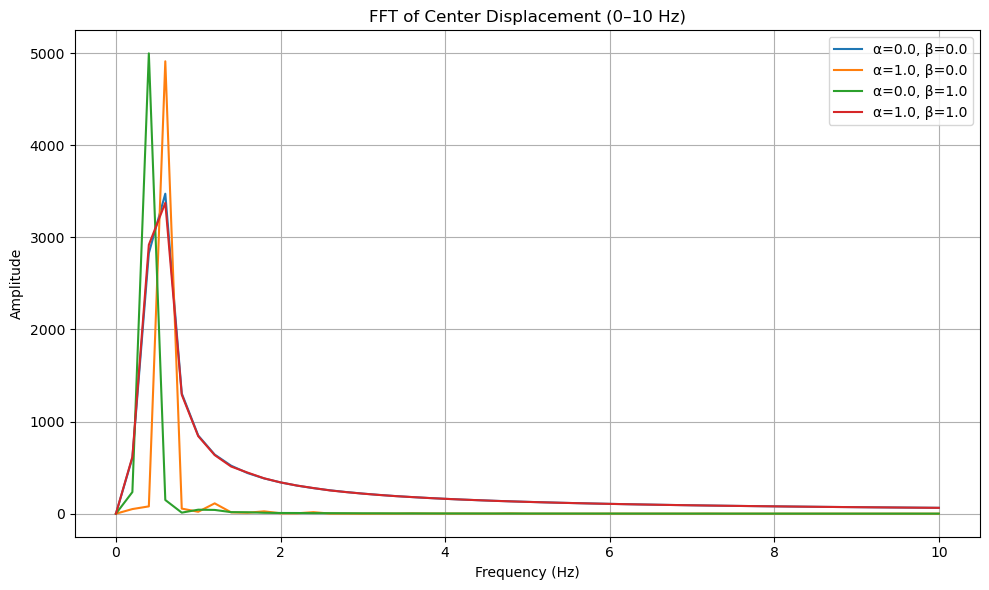

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq

# === Function to compute displacement over time for modal analysis ===
def wave_solver_modes(N, dt, T, alpha=0.0, beta=0.0):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    Nt = int(T / dt)
    times = np.linspace(0, T, Nt + 1)

    # Material properties
    E = 1.0 * (1 + alpha * x)
    rho = 1.0 * (1 + beta * x)
    E_half = 0.5 * (E[:-1] + E[1:])

    # Initial conditions: uniform mode 1 excitation
    u = np.sin(np.pi * x)
    v = np.zeros_like(x)
    u[0] = 0.0
    u[-1] = 0.0

    center_idx = N // 2
    u_center = [u[center_idx]]

    for _ in range(Nt):
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        u_center.append(u[center_idx])

    return times, np.array(u_center)


# Simulation for different (alpha, beta) combinations
results = {}
param_cases = [
    (0.0, 0.0),  # uniform
    (1.0, 0.0),  # stiffening
    (0.0, 1.0),  # densifying
    (1.0, 1.0)   # stiffening + densifying
]

for alpha, beta in param_cases:
    t, uc = wave_solver_modes(N=200, dt=0.0005, T=5.0, alpha=alpha, beta=beta)
    results[(alpha, beta)] = (t, uc)

# Perform FFT to extract frequency content
fft_results = {}
for key, (t, u) in results.items():
    n = len(t)
    u_fft = np.abs(fft(u - np.mean(u)))[:n//2]
    freqs = fftfreq(n, d=t[1]-t[0])[:n//2]
    fft_results[key] = (freqs, u_fft)

# Display dominant frequency for each case
print("Dominant frequencies (in Hz) for each (alpha, beta):")
for key, (freqs, u_fft) in fft_results.items():
    dominant_idx = np.argmax(u_fft)
    dominant_freq = freqs[dominant_idx]
    print(f"alpha={key[0]}, beta={key[1]}: Dominant Frequency = {dominant_freq:.4f} Hz")

# Plot the FFT for each case, limited to 0–10 Hz
plt.figure(figsize=(10, 6))
for key, (freqs, u_fft) in fft_results.items():
    mask = freqs <= 10  # Limit frequency to 0–10 Hz
    plt.plot(freqs[mask], u_fft[mask], label=f"α={key[0]}, β={key[1]}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT of Center Displacement (0–10 Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Part 4 Question 2

## Wave Localization Simulation: Code and Mathematical Explanation

This code simulates wave propagation in a 1D elastic medium (such as a cantilever beam) with **non-uniform material properties**, using a localized initial displacement. The wave equation is solved numerically using the Runge-Kutta 4th-order (RK4) method.

---

### Mathematical Model

We solve the non-uniform 1D wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x}\left(E(x) \frac{\partial u}{\partial x}\right)
$
where:
- $ u(x,t) $ is the displacement,
- $ E(x) $ is the spatially varying stiffness (Young’s modulus),
- $ \rho(x) $ is the spatially varying density.

Dirichlet boundary conditions are applied at both ends: $ u(0,t) = u(1,t) = 0 $.

---

### Function Descriptions

- `initial_displacement(x)`:
  Returns a **Gaussian pulse** centered at $ x = 0.25 $, defined as:
  $
  u(x, 0) = e^{-100(x - 0.25)^2}
  $
  This creates a highly localized initial wave packet.

- `initial_velocity(x)`:
  Initializes the velocity field to zero across the domain: $ \frac{\partial u}{\partial t}(x,0) = 0 $.

- `simulate_localization(N, dt, T, E0, alpha, rho0, beta)`:
  Solves the wave equation over time `T` using `N` spatial intervals and time step `dt`.
  - `E(x) = E_0 (1 + \alpha x)` is the spatial stiffness profile.
  - `rho(x) = \rho_0 (1 + \beta x)` is the spatial density profile.
  - The spatial domain is discretized using a finite difference grid, and wave propagation is simulated using the RK4 method.
  - Snapshots of the solution `u(x,t)` are saved at regular intervals (`t = 0.00, 0.05, 0.10, ..., T`).

---

### Plotting

The final section plots all displacement snapshots over time to visualize wave propagation. Since the material properties vary with position, the wave exhibits **localization effects**, such as slower or attenuated motion in regions of higher density or stiffness.

This example is useful for studying **wave trapping, dispersion, or reflection** caused by material inhomogeneities.

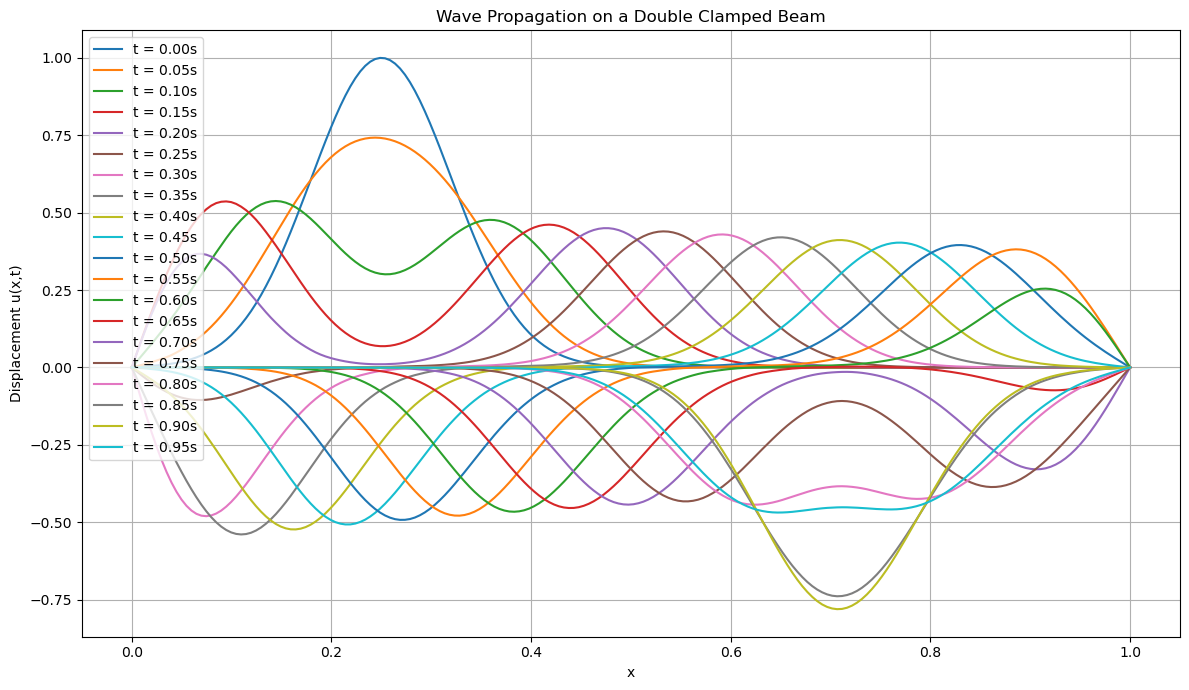

In [10]:
#Q2
import numpy as np
import matplotlib.pyplot as plt
# Define initial conditions (localized displacement)
def initial_displacement(x):
    return np.exp(-100 * (x - 0.25)**2)
def initial_velocity(x):
    return np.zeros_like(x)
def simulate_localization(N, dt, T, E0=1.0, alpha=2.0, rho0=1.0, beta=1.0):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    u = initial_displacement(x)
    v = initial_velocity(x)

    E = stiffness_profile(x, E0, alpha)
    rho = density_profile(x, rho0, beta)
    E_half = 0.5 * (E[:-1] + E[1:])

    t = 0.0
    snapshots = []
    times = []
    while t < T:
        if abs(t % 0.05) < dt:
            snapshots.append(u.copy())
            times.append(t)
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt
    return x, snapshots, times
# Run the simulation
N = 200
dt = 0.001
T = 1.0
x, snapshots, times = simulate_localization(N, dt, T)
# Plot results
plt.figure(figsize=(12, 7))
for i, u in enumerate(snapshots):
    plt.plot(x, u, label=f't = {times[i]:.2f}s')
plt.xlabel('x')
plt.ylabel('Displacement u(x,t)')
plt.title('Wave Propagation on a Double Clamped Beam')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Part 4 Question 3

## Q3: Mode Localization with Stiffness Jump — Code and Mathematical Explanation

This simulation studies how wave energy propagates in a nonuniform 1D elastic rod and whether **material inhomogeneities** (such as a stiffness jump or graded density) lead to **mode localization** — i.e., when vibrational energy becomes confined to part of the domain.

---

### Mathematical Model

We solve the variable-coefficient 1D wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x} \left( E(x) \frac{\partial u}{\partial x} \right)
$
subject to Dirichlet boundary conditions:
$
u(0, t) = u(1, t) = 0
$
and initial conditions:
$
u(x, 0) = u_0(x), \quad \frac{\partial u}{\partial t}(x, 0) = v_0(x)
$

---

### Function Descriptions

- `initial_displacement(x)`:
  Initializes a **localized Gaussian pulse** centered at $ x = 0.25 $. This simulates a small perturbation or impact in the left region of the rod.

- `initial_velocity(x)`:
  Initializes the velocity field to zero at all points.

- `stiffness_profile(x, E0=1.0, alpha=2.0)`:
  Defines a piecewise stiffness profile with a **jump at the midpoint**:
  
  $
  E(x) = 
  \begin{cases}
    E_0, & x \leq 0.5 \\
    E_0 (1 + \alpha), & x > 0.5
  \end{cases}
  $

  This models a rod composed of two materials — one stiffer than the other — with an abrupt transition.

- `density_profile(x, rho0=1.0, beta=1.0)`:
  Models a **linearly increasing density**:
  $
  \rho(x) = \rho_0 (1 + \beta x)
  $
  This introduces a mass gradient, which affects wave propagation speed and energy distribution.

- `simulate_localization(N, dt, T)`:
  Solves the wave equation using a **finite difference spatial discretization** and **4th-order Runge-Kutta (RK4)** for time stepping.
  
  It records the displacement field `u(x, t)` at time intervals of 0.05 seconds and returns these snapshots.

---

### Visualization

The simulation is run with:
- Spatial grid size `N = 200`
- Time step `dt = 0.001`
- Total simulation time `T = 1.0` second

The plot shows multiple wave profiles over time. By observing how the wave propagates across the domain:
- If the wave is **reflected or trapped** in the left region, it suggests **mode localization**.
- If the wave transmits and spreads evenly, localization is not significant.

---

### Objective

This code helps investigate:
- Whether material discontinuities like a **stiffness jump** and **density gradient** lead to **vibrational energy confinement**.
- How structural inhomogeneities affect wave speed and the shape of oscillation modes.

This phenomenon, known as **mode localization**, is important in structural dynamics and materials science, particularly in designing systems for vibration isolation or energy focusing.


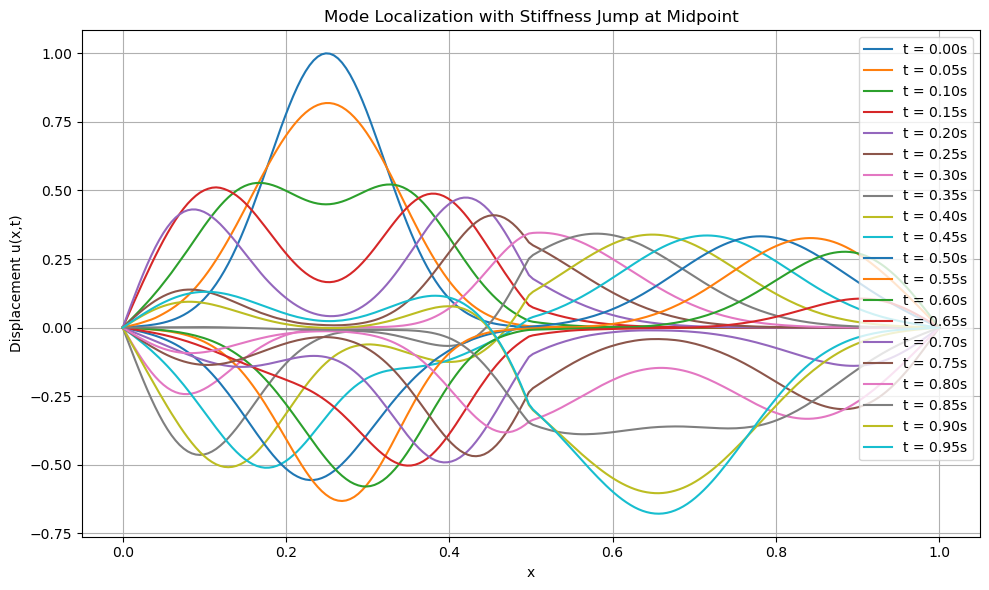

In [11]:
# Q3
import numpy as np
import matplotlib.pyplot as plt
# Define initial conditions (localized displacement)
def initial_displacement(x):
    return np.exp(-100 * (x - 0.25)**2)
def initial_velocity(x):
    return np.zeros_like(x)
# Define variable stiffness or density profiles
def stiffness_profile_jump(x, E0=1.0, alpha=2.0):
    return E0 * (1 + alpha * (x > 0.5))  # Jump in stiffness at midpoint
def density_profile(x, rho0=1.0, beta=1.0):
    return rho0 * (1 + beta * x)
def simulate_localization(N, dt, T):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]

    # Material properties
    E = stiffness_profile_jump(x)
    rho = density_profile(x)
    E_half = 0.5 * (E[:-1] + E[1:])

    # Initial conditions
    u = initial_displacement(x)
    v = initial_velocity(x)

    # Time stepping
    t = 0.0
    snapshots = []
    times = []

    while t < T:
        if abs(t % 0.05) < dt:
            snapshots.append(u.copy())
            times.append(t)
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt

    return x, snapshots, times
# Run simulation
N = 200
dt = 0.001
T = 1.0
x, snapshots, times = simulate_localization(N, dt, T)
# Plot results
plt.figure(figsize=(10, 6))
for i, u in enumerate(snapshots):
    plt.plot(x, u, label=f't = {times[i]:.2f}s')
plt.xlabel('x')
plt.ylabel('Displacement u(x,t)')
plt.title('Mode Localization with Stiffness Jump at Midpoint')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Part 4 Question 4

## Sensitivity Study of Wave Equation to Material Properties

This code performs a numerical study on how variations in material stiffness `E(x)` and density `ρ(x)` affect the solution of the 1D wave equation. It includes simulation, error analysis, frequency analysis via FFT, and result visualization.

---

### Mathematical Model

The wave equation solved is:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x}\left(E(x) \frac{\partial u}{\partial x}\right)
$
with Dirichlet boundary conditions:
$
u(0, t) = u(1, t) = 0
$

This model allows for spatially varying stiffness $ E(x) $ and density $ \rho(x) $, which simulate non-uniform material properties.

---

### `wave_solver_sensitivity(...)`

This function solves the wave equation using the RK4 time integrator. It accepts:
- `N`: number of spatial intervals,
- `dt`: time step size,
- `T`: final simulation time,
- `E_func` and `rho_func`: functions that define spatially varying stiffness and density.

The function initializes the solution using the manufactured exact solution `u(x, 0) = sin(πx) * cos(πt)` and computes a time history of displacement at the midpoint of the domain. It returns:
- spatial grid `x`,
- final displacement `u(x, T)`,
- array of midpoint displacements over time.

---

### Simulation Cases

Three simulations are run:
1. **Baseline**: Uniform stiffness and density.
2. **Linear E(x)**: Stiffness increases linearly with position.
3. **Linear ρ(x)**: Density increases linearly with position.

These are tested using:
- `N = 400` (fine spatial resolution),
- `dt = 1e-3`,
- `T = 2.0` seconds.

---

### Error Analysis

L2 errors are computed between each perturbed case and the baseline:
$
\text{error} = \sqrt{h \sum_i (u_{\text{perturbed}}(x_i) - u_{\text{baseline}}(x_i))^2}
$

This quantifies how the final displacement field deviates due to changes in material properties.

---

### Frequency Analysis

The midpoint displacement history is analyzed using the FFT:
- `rfft` computes the frequency-domain amplitude spectrum.
- `rfftfreq` provides the frequency bins.
- The **dominant frequency** is identified as the frequency with the highest amplitude.

This helps reveal how changes in `E(x)` or `ρ(x)` alter the wave’s oscillation characteristics.

---

### Visualization

1. **Final Displacement Plot**: Shows how the spatial solution at $ T = 2.0 $ differs between cases.
2. **FFT Plot**: Displays the amplitude spectrum of midpoint displacement for each case, limited to frequencies [0, 5 Hz].

---

### Summary Table

A table is constructed to compare:
- The L2 error for each perturbed case relative to the baseline.
- The dominant frequency of vibration observed at the midpoint.

This provides a concise summary of the sensitivity of the solution to small material property variations.


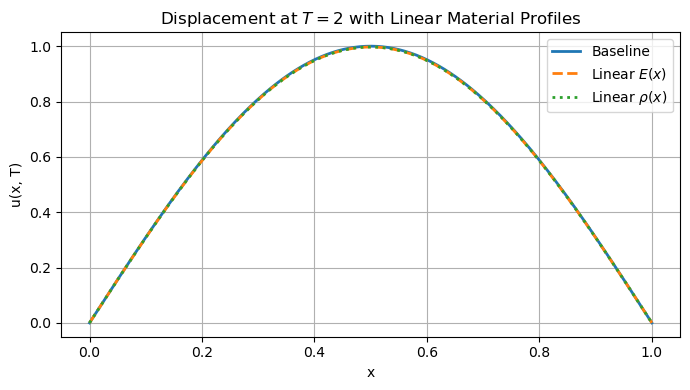

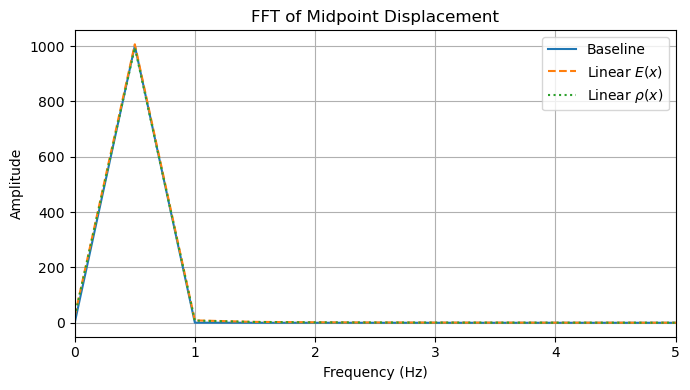

,Case,L2 Error,Dominant Frequency (Hz)
0,Baseline,—,0.50
1,Linear E(x),2.12e-03,0.50
2,Linear rho(x),2.11e-03,0.50


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
import pandas as pd

# --- Wave equation solver ---
def wave_solver_sensitivity(N, dt, T, E_func, rho_func):
    x = np.linspace(0, 1, N + 2)
    h = x[1] - x[0]
    Nt = int(T / dt)

    # Initial conditions
    u = exact_solution(x, 0)
    v = exact_velocity(x, 0)
    u[0] = u[-1] = 0

    # Material properties
    E_vals = E_func(x)
    rho_vals = rho_func(x)
    E_half = 0.5 * (E_vals[:-1] + E_vals[1:])

    mid_val_history = [u[N // 2]]

    for _ in range(Nt):
        u, v = rk4_step(u, v, dt, E_half, rho_vals, h, N)
        mid_val_history.append(u[N // 2])

    return x, u, np.array(mid_val_history)


# --- Simulation parameters ---
N = 400
dt = 1e-3
T = 2.0

# --- Run simulations ---
x, u_base, u_mid_base = wave_solver_sensitivity(N, dt, T, lambda x: np.ones_like(x), lambda x: np.ones_like(x))
_, u_Elin, u_mid_Elin = wave_solver_sensitivity(N, dt, T, lambda x: stiffness_profile(x, 1, 0.05), lambda x: np.ones_like(x))
_, u_rholin, u_mid_rholin = wave_solver_sensitivity(N, dt, T, lambda x: np.ones_like(x), lambda x: density_profile(x, 1, 0.05))

# --- Error and FFT analysis ---
h = x[1] - x[0]
e_Elin = np.sqrt(h * np.sum((u_Elin - u_base)**2))
e_rholin = np.sqrt(h * np.sum((u_rholin - u_base)**2))

freqs = rfftfreq(len(u_mid_base), dt)
amp_base = np.abs(rfft(u_mid_base))
amp_Elin = np.abs(rfft(u_mid_Elin))
amp_rholin = np.abs(rfft(u_mid_rholin))

f_dominant_base = freqs[np.argmax(amp_base)]
f_dominant_Elin = freqs[np.argmax(amp_Elin)]
f_dominant_rholin = freqs[np.argmax(amp_rholin)]

# --- Plot final displacement ---
plt.figure(figsize=(7, 4))
plt.plot(x, u_base, label='Baseline', linewidth=2)
plt.plot(x, u_Elin, '--', label='Linear $E(x)$', linewidth=2)
plt.plot(x, u_rholin, ':', label='Linear $\\rho(x)$', linewidth=2)
plt.title('Displacement at $T = 2$ with Linear Material Profiles')
plt.xlabel('x')
plt.ylabel('u(x, T)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot FFTs ---
plt.figure(figsize=(7, 4))
plt.plot(freqs, amp_base, label='Baseline')
plt.plot(freqs, amp_Elin, '--', label='Linear $E(x)$')
plt.plot(freqs, amp_rholin, ':', label='Linear $\\rho(x)$')
plt.xlim(0, 5)
plt.title('FFT of Midpoint Displacement')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Summary table ---
df = pd.DataFrame({
    "Case": ["Baseline", "Linear E(x)", "Linear rho(x)"],
    "L2 Error": ["—", f"{e_Elin:.2e}", f"{e_rholin:.2e}"],
    "Dominant Frequency (Hz)": [f"{f_dominant_base:.2f}", f"{f_dominant_Elin:.2f}", f"{f_dominant_rholin:.2f}"]
})
display(df)

# Part 4 Question 5

## Frequency Shift due to Material Gradients: Explanation and Mathematical Basis

This code investigates how a non-uniform distribution of material properties affects the **natural frequencies** of a 1D elastic medium. Specifically, it computes the **first natural frequency** of the system using a time-domain simulation and FFT analysis.

---

### Mathematical Model

The governing equation is the spatially-varying 1D wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x}\left(E(x) \frac{\partial u}{\partial x} \right)
$

with fixed boundary conditions:
$
u(0, t) = u(1, t) = 0
$

The stiffness and density vary linearly with position:
- $ E(x) = E_0 (1 + \alpha x) $
- $ \rho(x) = \rho_0 (1 + \beta x) $

This spatial variation causes a **tapering effect**, which alters the vibrational properties of the medium.

---

### Function Descriptions

- `initial_displacement(x)`:
  Initializes displacement as $ u(x, 0) = \sin(\pi x) $, which primarily excites the **first mode** of vibration.

- `initial_velocity(x)`:
  Initializes the velocity field to zero: $ \frac{\partial u}{\partial t}(x, 0) = 0 $.

- `simulate_frequency_shift(...)`:
  Numerically solves the wave equation using RK4 time integration with non-uniform `E(x)` and `ρ(x)`. It records the displacement at the midpoint of the domain (`sensor_index`) over time. This time series will be used to extract frequency content.

---

### Frequency Analysis

After the simulation:
- The midpoint displacement history is stored in `signal`.
- The Fast Fourier Transform (FFT) is applied to this signal using `scipy.fft.fft` and `fftfreq`.
- The **frequency with the highest amplitude** is identified as the dominant natural frequency of the system.

This corresponds to the **first natural frequency**, since the initial condition only excites the first mode.

---

### Visualization

A frequency spectrum is plotted:
- The FFT amplitude vs. frequency.
- A vertical line marks the peak frequency detected.
- The plot helps visualize how tapering the material properties shifts the frequency compared to a uniform case.

This experiment demonstrates how structural gradients (non-uniform stiffness/density) can influence vibrational behavior, which is useful in structural design, materials engineering, and vibration control.


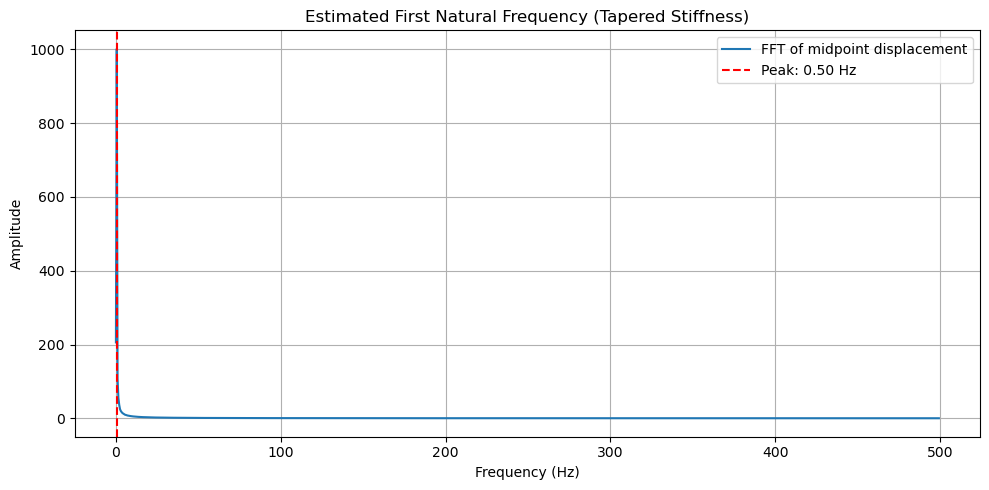

In [13]:
#Q5
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq
# Initial displacement pulse to excite low frequencies
def initial_displacement(x):
    return np.sin(np.pi * x)  # Excites primarily the first mode
def initial_velocity(x):
    return np.zeros_like(x)
# Gradient-based stiffness and density
def simulate_frequency_shift(N, dt, T, E0=1.0, alpha=2.0, rho0=1.0, beta=1.0):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    E = stiffness_profile(x, E0, alpha)
    rho = density_profile(x, rho0, beta)
    E_half = 0.5 * (E[:-1] + E[1:])
    u = initial_displacement(x)
    v = initial_velocity(x)

    t = 0.0
    sensor_history = []
    sensor_index = N // 2  # probe mid-span displacement
    while t < T:
        sensor_history.append(u[sensor_index])
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt
    return sensor_history, dt
# Run simulation
N = 200
dt = 0.001
T = 2.0
signal, dt = simulate_frequency_shift(N, dt, T)
# FFT to estimate first natural frequency
n = len(signal)
frequencies = fftfreq(n, dt)[:n//2]
amplitudes = np.abs(fft(signal))[:n//2]
peak_index = np.argmax(amplitudes)
f_peak = frequencies[peak_index]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(frequencies, amplitudes, label='FFT of midpoint displacement')
plt.axvline(f_peak, color='r', linestyle='--', label=f'Peak: {f_peak:.2f} Hz')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Estimated First Natural Frequency (Tapered Stiffness)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Part 4 Question 6

## Energy Evolution in a Nonuniform Elastic Rod: Explanation and Mathematical Background

This code simulates wave propagation in a 1D elastic rod with spatially varying stiffness and density. It tracks the **kinetic**, **potential**, and **total mechanical energy** of the system over time to assess conservation and wave behavior.

---

### Mathematical Model

We solve the 1D wave equation:
$
\rho(x) \frac{\partial^2 u}{\partial t^2} = \frac{\partial}{\partial x} \left( E(x) \frac{\partial u}{\partial x} \right)
$
where:
- $ u(x,t) $: displacement field,
- $ E(x) $: spatially varying Young’s modulus (stiffness),
- $ \rho(x) $: spatially varying density.

The solution is advanced in time using a 4th-order Runge-Kutta scheme (`rk4_step`). Boundary conditions are Dirichlet: $ u(0,t) = u(1,t) = 0 $.

---

### Function Descriptions

- `initial_displacement(x)`:
  Returns a localized **Gaussian pulse** centered near $ x = 0.3 $. This provides an initial disturbance in the system.

- `initial_velocity(x)`:
  Initializes the velocity field to zero everywhere.

- `simulate_energy_evolution(...)`:
  - Sets up the grid and material properties:
    $
    E(x) = E_0 (1 + \alpha x), \quad \rho(x) = \rho_0 (1 + \beta x)
    $
  - Initializes displacement and velocity fields.
  - Defines `compute_energy(u, v)` to compute:
    - **Kinetic energy**:
      $
      KE = \frac{1}{2} \sum \rho(x_i) v(x_i)^2 h
      $
    - **Potential energy**:
      $
      PE = \frac{1}{2} \sum E(x_{i+1/2}) \left( \frac{u_{i+1} - u_i}{h} \right)^2 h
      $
    - The sum is approximated via trapezoidal integration with midpoint values.
  - Time integration loop stores energy values at each step.

---

### Analysis and Output

After the simulation:
- The code prints the **peak values** of kinetic, potential, and total energy, and the times at which they occur.
- A plot shows how energy components evolve over time.

This simulation helps assess:
- **Energy conservation** in numerical integration.
- How energy is exchanged between kinetic and potential forms.
- How material gradients affect wave energy transport and localization.

This is useful in structural dynamics, materials engineering, and vibration analysis of nonuniform media.


Peak Kinetic Energy: 7.5140 Joules at t = 0.5940 s
Peak Potential Energy: 10.0203 Joules at t = 0.0000 s
Peak Total Energy: 10.0203 Joules at t = 0.0010 s


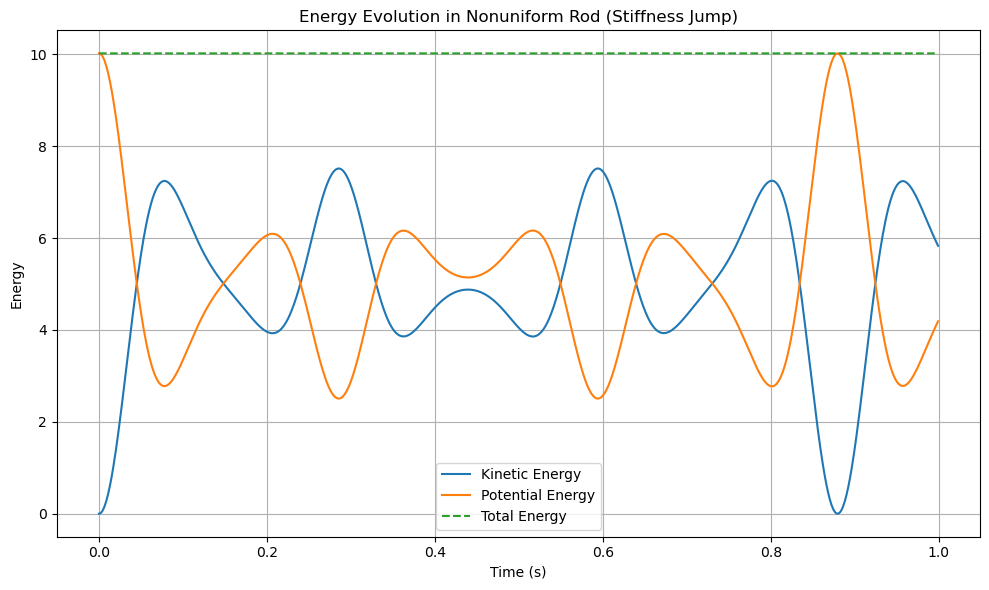

In [14]:
#Q6
import numpy as np
import matplotlib.pyplot as plt
# Initial displacement and velocity
def initial_displacement(x):
    return np.exp(-100 * (x - 0.3)**2)  # Localized Gaussian pulse
def initial_velocity(x):
    return np.zeros_like(x)
def simulate_energy_evolution(N, dt, T, E0=1.0, alpha=2.0, rho0=1.0, beta=1.0):
    L = 1.0
    x = np.linspace(0, L, N + 2)
    h = x[1] - x[0]
    E = stiffness_profile(x, E0, alpha)
    rho = density_profile(x, rho0, beta)
    E_half = 0.5 * (E[:-1] + E[1:])
    u = initial_displacement(x)
    v = initial_velocity(x)
    def compute_energy(u, v):
        # Kinetic Energy: 1/2 * rho * v^2
        KE = 0.5 * rho * v**2
        total_KE = np.sum(KE) * h
        # Potential Energy: 1/2 * E * (du/dx)^2
        du_dx = (u[1:] - u[:-1]) / h
        E_local = 0.5 * (E[1:] + E[:-1])
        PE = 0.5 * E_local * du_dx**2
        total_PE = np.sum(PE) * h
        return total_KE, total_PE
    t = 0.0
    times = []
    KE_list = []
    PE_list = []
    TE_list = []
    while t < T:
        KE, PE = compute_energy(u, v)
        times.append(t)
        KE_list.append(KE)
        PE_list.append(PE)
        TE_list.append(KE + PE)
        u, v = rk4_step(u, v, dt, E_half, rho, h, N)
        t += dt
    return times, KE_list, PE_list, TE_list
# Run the simulation
N = 200
dt = 0.001
T = 1.0
times, KE_list, PE_list, TE_list = simulate_energy_evolution(N, dt, T)
# Identify and print energy peaks
KE_max = max(KE_list)
PE_max = max(PE_list)
TE_max = max(TE_list)
KE_time = times[np.argmax(KE_list)]
PE_time = times[np.argmax(PE_list)]
TE_time = times[np.argmax(TE_list)]
print(f"Peak Kinetic Energy: {KE_max:.4f} Joules at t = {KE_time:.4f} s")
print(f"Peak Potential Energy: {PE_max:.4f} Joules at t = {PE_time:.4f} s")
print(f"Peak Total Energy: {TE_max:.4f} Joules at t = {TE_time:.4f} s")
# Plot energy evolution
plt.figure(figsize=(10, 6))
plt.plot(times, KE_list, label='Kinetic Energy')
plt.plot(times, PE_list, label='Potential Energy')
plt.plot(times, TE_list, label='Total Energy', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Energy Evolution in Nonuniform Rod (Stiffness Jump)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()